In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet("training_data.parquet")

All data is being pulled from Financial Modeling Prep API using free version, which limits us to 250 requests a day and is available only for US companies, 5 years back and only yearly data. Our data consists of 300 records, 4 dates from 2020 to 2023 for each unique ticker so in total we have data for 75 companies.

Additionally, we append target vector which is defined based on next year market cap movement:
- if X > X-1 then X.target = 1
- if X < X-1 then X.target = 0

So if AAPL has higher market cap in 2021 than in 2020, then 2020 will have target set to 1. As such, 2024 data can't have a target so we drop it.

In [3]:
df.head()

,date,symbol,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,sellingAndMarketingExpenses,sellingGeneralAndAdministrativeExpenses,...,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,marketCap,target
0,2023-09-29,AAPL,383285000000,214137000000,169148000000,0.441311,2.991500e+10,0,0,24932000000,...,-108488000000,0,5760000000,30737000000,24977000000,110543000000,-10959000000,99584000000,2670779095140,1.0
1,2022-09-23,AAPL,394328000000,223546000000,170782000000,0.433096,2.625100e+10,0,0,25094000000,...,-110749000000,0,-10952000000,24977000000,35929000000,122151000000,-10708000000,111443000000,2411450364260,1.0
2,2021-09-24,AAPL,365817000000,212981000000,152836000000,0.417794,2.191400e+10,0,0,21973000000,...,-93353000000,0,-3860000000,35929000000,39789000000,104038000000,-11085000000,92953000000,2422287817320,0.0
3,2020-09-25,AAPL,274515000000,169559000000,104956000000,0.382332,1.875200e+10,0,0,19916000000,...,-86820000000,0,-10435000000,39789000000,50224000000,80674000000,-7309000000,73365000000,1915229798160,1.0
4,2022-12-30,META,116609000000,25249000000,91360000000,0.783473,3.533800e+10,11816000000,15262000000,27078000000,...,-22136000000,-638000000,-1269000000,15596000000,16865000000,50475000000,-31431000000,19044000000,317456920000,1.0


In [4]:
df.shape

(300, 103)

Our data consits of 4 tables pulled from API:
- income statement (columns 3 - 29) which shows income sources and costs of a company
- balance sheet (columns 30 - 73) showing company assets, as well as equity and liabilities
- cashflow statement (columns 74 - 100), where we can identify on what a company spends its money
- market capitalisation, which shows total value of all shares available for trading

Additionally, we create a "target" feature which identifies if market cap will increase next year. Market capitalization that we're tracking is total worth of shares that a company has submitted for trading. For example if a company has issued 100m shares each valued at \\$5, then market cap is \\$500m. As such, it can just as well be used for tracking share price changes.

In [5]:
print(f"Count of NULL values: {df.isnull().sum().sum()}")

Count of NULL values: 0


In [6]:
df["target"].value_counts()

target
1.0    193
0.0    107
Name: count, dtype: int64

Two points important to note that, one - we don't have any missing values, and two - our dataset is unbalanced as about 2/3 of all records have a target of 1.

## Income statement

In [7]:
frames = [df.iloc[:, :2], df.iloc[:, 2:30], df.iloc[:, -1]]
income_statement = pd.concat(frames, axis = 1)
income_statement

,date,symbol,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,sellingAndMarketingExpenses,sellingGeneralAndAdministrativeExpenses,...,incomeBeforeTax,incomeBeforeTaxRatio,incomeTaxExpense,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,target
0,2023-09-29,AAPL,383285000000,214137000000,169148000000,0.441311,2.991500e+10,0,0,24932000000,...,113736000000,0.296740,16741000000,96995000000,0.253062,6.1600,6.1300,15744231000,15812547000,1.0
1,2022-09-23,AAPL,394328000000,223546000000,170782000000,0.433096,2.625100e+10,0,0,25094000000,...,119103000000,0.302040,19300000000,99803000000,0.253096,6.1500,6.1100,16215963000,16325819000,1.0
2,2021-09-24,AAPL,365817000000,212981000000,152836000000,0.417794,2.191400e+10,0,0,21973000000,...,109207000000,0.298529,14527000000,94680000000,0.258818,5.6700,5.6100,16701272000,16864919000,0.0
3,2020-09-25,AAPL,274515000000,169559000000,104956000000,0.382332,1.875200e+10,0,0,19916000000,...,67091000000,0.244398,9680000000,57411000000,0.209136,3.3100,3.2800,17352119000,17528214000,1.0
4,2022-12-30,META,116609000000,25249000000,91360000000,0.783473,3.533800e+10,11816000000,15262000000,27078000000,...,28819000000,0.247142,5619000000,23200000000,0.198955,8.6300,8.5900,2687000000,2702000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2019-12-31,MSCI,1557796000,294961000,1262835000,0.810655,9.833400e+07,110093000,219298000,329391000,...,603318000,0.387289,39670000,563648000,0.361824,6.6600,6.5900,84644000,85536000,1.0
296,2022-12-30,BCS,24956000000,0,24956000000,1.000000,0.000000e+00,1770000000,500000000,2270000000,...,7012000000,0.280975,1039000000,7012000000,0.237538,0.3100,0.3000,16333000000,16867000000,0.0
297,2021-12-31,BCS,21940000000,0,21940000000,1.000000,0.000000e+00,1568000000,399000000,1967000000,...,8414000000,0.383500,1188000000,8414000000,0.319462,0.3700,0.3600,16985000000,17420000000,1.0
298,2020-12-31,BCS,21766000000,0,21766000000,1.000000,0.000000e+00,5636000000,330000000,5636000000,...,3065000000,0.140816,604000000,3065000000,0.109483,0.0882,0.0864,17300000000,17668000000,1.0


In [8]:
income_statement.iloc[:1, 1:-1].T

,0
symbol,AAPL
revenue,383285000000
costOfRevenue,214137000000
grossProfit,169148000000
grossProfitRatio,0.441311
researchAndDevelopmentExpenses,29915000000.0
generalAndAdministrativeExpenses,0
sellingAndMarketingExpenses,0
sellingGeneralAndAdministrativeExpenses,24932000000
otherExpenses,382000000


Idea of an income statement is that going down the chart we will see the maximum amount of money that a company has made - revenue, to what it ultimately have kept by the end of the financial period - net income. For each "section" there are associated costs that lower the earnings. Few examples:
- gross profit is revenue minus its cost
- operating expenses include R&D expenses as well as general and administrative expenses
- those expenses are then summed up with revenue costs and total in costAndExpenses
- EBITDA (earning before interest, taxes, depreciation and amortization) can be calculated then as revenue - costAndEspenses or as grossProfit - operatingExpenses

As we keep going down the ledger we end up with remaining income. We then divide it by amount of shares outstanding (total amount of shares admitted for trading) to get EPS, earnings per one share. We will need to consider if all that information would be needed or if we should focus on most important data points, like income or costAndExpenses.

In [9]:
income_statement.columns

Index(['date', 'symbol', 'revenue', 'costOfRevenue', 'grossProfit',
       'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio',
       'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome',
       'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut',
       'weightedAverageShsOutDil', 'target'],
      dtype='object')

Checking the columns we can see that we already start with some ratios calculated (grossProfitRatio or ebitdaratio for example). They will have high correlation with their related values, so we should consider either keeping them and related features, or the other way around.

Dropping diluted EPS and shares outstanding columns is safe as they don't give us any important information for evaluating market cap.

In [10]:
income_statement.drop(["epsdiluted", "weightedAverageShsOut", "weightedAverageShsOutDil"], axis=1, inplace=True)

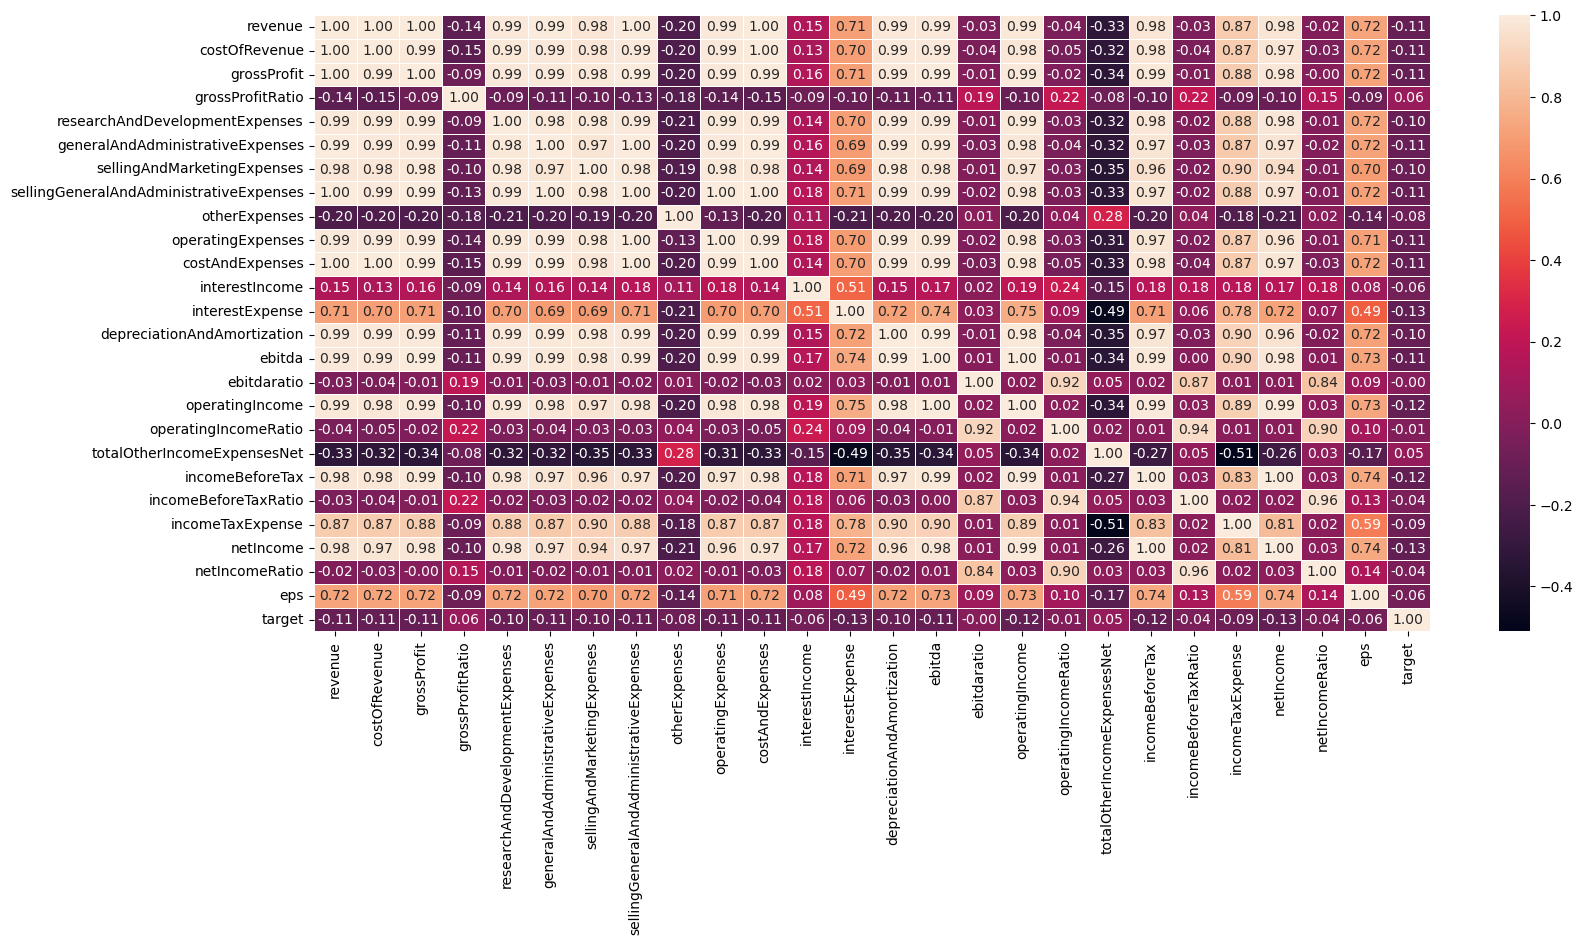

In [11]:
corr = income_statement.iloc[:, 2:].corr()

plt.figure(figsize=(18, 8))
sns.heatmap(corr, annot=True, linewidth=0.5, fmt='.2f');

Unfortunately correlation doesn't tell us which features have high impact on our target value. We can see however, that ratio features have the lowest impact, so we will remove them.

In [12]:
income_statement.drop(["grossProfitRatio", "ebitdaratio", "operatingIncomeRatio", "incomeBeforeTaxRatio", "netIncomeRatio"], axis=1, inplace=True)

In [13]:
income_statement.shape

(300, 23)

## Balance sheet

In [14]:
frames = [df.iloc[:, :2], df.iloc[:, 30:74], df.iloc[:, -1]]
balance_sheet = pd.concat(frames, axis = 1)
balance_sheet

,date,symbol,cashAndCashEquivalents,shortTermInvestments,cashAndShortTermInvestments,netReceivables,inventory,otherCurrentAssets,totalCurrentAssets,propertyPlantEquipmentNet,...,othertotalStockholdersEquity,totalStockholdersEquity,totalEquity,totalLiabilitiesAndStockholdersEquity,minorityInterest,totalLiabilitiesAndTotalEquity,totalInvestments,totalDebt,netDebt,target
0,2023-09-29,AAPL,29965000000,31590000000,61555000000,60985000000,-1618000000,14695000000,143566000000,54376000000,...,0.000000e+00,62146000000,62146000000,352583000000,0,352583000000,132134000000,111088000000,81123000000,1.0
1,2022-09-23,AAPL,23646000000,24658000000,48304000000,60932000000,1484000000,21223000000,135405000000,52534000000,...,0.000000e+00,50672000000,50672000000,352755000000,0,352755000000,145463000000,132480000000,108834000000,1.0
2,2021-09-24,AAPL,34940000000,27699000000,62639000000,51506000000,-2642000000,14111000000,134836000000,49527000000,...,0.000000e+00,63090000000,63090000000,351002000000,0,351002000000,155576000000,136522000000,101582000000,0.0
3,2020-09-25,AAPL,38016000000,52927000000,90943000000,37445000000,-127000000,11264000000,143713000000,45336000000,...,0.000000e+00,65339000000,65339000000,323888000000,0,323888000000,153814000000,122278000000,84262000000,1.0
4,2022-12-30,META,14681000000,26057000000,40738000000,13466000000,0,5345000000,59549000000,92191000000,...,6.444400e+10,125713000000,125713000000,185727000000,0,185727000000,32258000000,26591000000,11910000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2019-12-31,MSCI,1506567000,0,1506567000,499268000,-39718000,75942000,2081777000,257114000,...,-2.214753e+09,-76714000,-76714000,4204439000,0,4204439000,0,3236070000,1729503000,1.0
296,2022-12-30,BCS,256351000000,-172043000000,256351000000,0,0,0,256351000000,3616000000,...,4.050000e+08,68292000000,69260000000,1513699000000,968000000,1513699000000,543702000000,124304000000,-132047000000,0.0
297,2021-12-31,BCS,238574000000,0,238574000000,0,0,0,238574000000,3555000000,...,3.480000e+08,69222000000,70211000000,1384285000000,989000000,1384285000000,664331000000,111626000000,-126948000000,1.0
298,2020-12-31,BCS,191127000000,0,191127000000,0,0,0,191127000000,4036000000,...,2.970000e+08,65797000000,66882000000,1349514000000,1085000000,1349514000000,685016000000,92137000000,-98990000000,1.0


In [15]:
balance_sheet.iloc[:1, 1:-1].T

,0
symbol,AAPL
cashAndCashEquivalents,29965000000
shortTermInvestments,31590000000
cashAndShortTermInvestments,61555000000
netReceivables,60985000000
inventory,-1618000000
otherCurrentAssets,14695000000
totalCurrentAssets,143566000000
propertyPlantEquipmentNet,54376000000
goodwill,0


Balance sheet outlines how much "stuff" a company owns and their financing sources. It is split into three main categories - assets, equity and debt. 
- Assets show a comprehensive summary of everything that a company owns, be it real estate, machines used for production, materials, finished or unfinished products, investments, cash, intelectual property, deferred incoming payments for products/services or even tax deferrals
- Equity is owners own value that was brought to the company. For big companies majority of equity cosits of issued shares, but equity also includes things like cars, patents or cash that small company owners bring when starting a company
- Debt is self-explanatory, it includes all external sources of financing including bank debt or leases, but also incoming payments that a company will have to make. It is split into current liabilities for which expected payments are within a year, and non-current liabilities which will need to be paid after at least a year

Assets always match equity + debt as every dollar needs to be accounted for. Balance sheets help us determine financial health of a company: a healthy company won't need to keep a large inventory, have productive assets, or have a good capital structure with managable amount of debt (debt helps a company grow faster, but too much of it will stunt its proft growth).

In [16]:
pd.value_counts(balance_sheet["totalAssets"] == balance_sheet["totalLiabilitiesAndTotalEquity"])

True    300
Name: count, dtype: int64

In [17]:
balance_sheet.columns

Index(['date', 'symbol', 'cashAndCashEquivalents', 'shortTermInvestments',
       'cashAndShortTermInvestments', 'netReceivables', 'inventory',
       'otherCurrentAssets', 'totalCurrentAssets', 'propertyPlantEquipmentNet',
       'goodwill', 'intangibleAssets', 'goodwillAndIntangibleAssets',
       'longTermInvestments', 'taxAssets', 'otherNonCurrentAssets',
       'totalNonCurrentAssets', 'otherAssets', 'totalAssets',
       'accountPayables', 'shortTermDebt', 'taxPayables', 'deferredRevenue',
       'otherCurrentLiabilities', 'totalCurrentLiabilities', 'longTermDebt',
       'deferredRevenueNonCurrent', 'deferredTaxLiabilitiesNonCurrent',
       'otherNonCurrentLiabilities', 'totalNonCurrentLiabilities',
       'otherLiabilities', 'capitalLeaseObligations', 'totalLiabilities',
       'preferredStock', 'commonStock', 'retainedEarnings',
       'accumulatedOtherComprehensiveIncomeLoss',
       'othertotalStockholdersEquity', 'totalStockholdersEquity',
       'totalEquity', 'totalLiabi

Similarly like with income statement, columns outlining stock amount have no bearing on company valuation, and neither does distinguishing between common and preferred stock. As such we can safely remove them. Remaining features will be analysed via correlation.

In [18]:
balance_sheet.drop(["commonStock", "preferredStock"], axis=1, inplace=True)

As balance_sheet dataframe has too many features to show, we will check only correlation for target column.

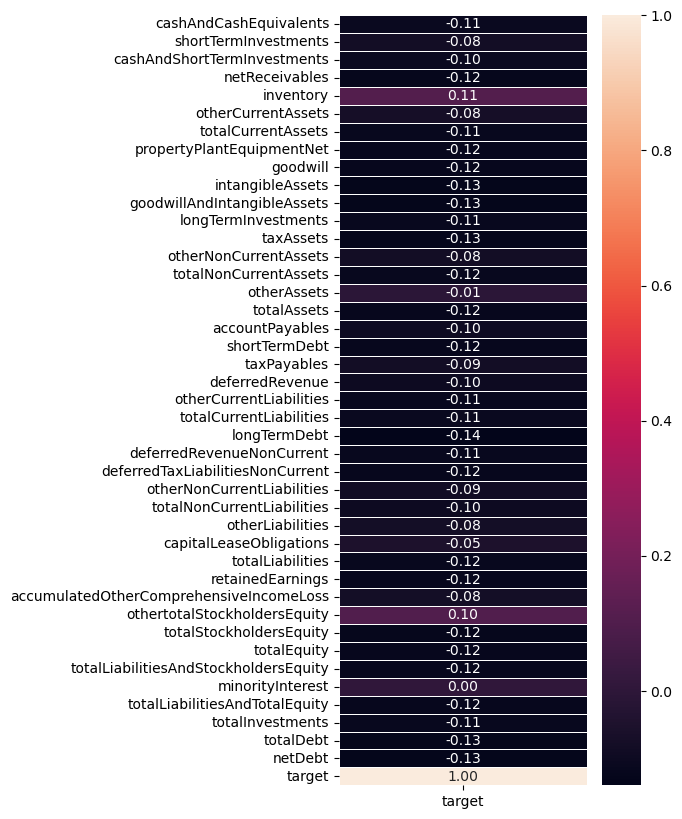

In [19]:
corr = balance_sheet.iloc[:, 2:].corr()
corr_target = corr.iloc[-1]

plt.figure(figsize=(4, 10))
sns.heatmap(pd.DataFrame(corr_target), annot=True, linewidth=0.5, fmt='.2f');

Majority of our features hover around 0.1 or -0.1. Notable exceptions are otherAssets and minorityInterest which have correlation next to zero, and capitalLeaseObligation with -0.05. We will remove all three as they are not major information points.

In [20]:
balance_sheet.drop(["otherAssets", "capitalLeaseObligations", "minorityInterest"], axis=1, inplace=True)

## Cashflow statement

In [21]:
frames = [df.iloc[:, :2], df.iloc[:, 75:101], df.iloc[:, -1]]
cashflow_statement = pd.concat(frames, axis = 1)
cashflow_statement

,date,symbol,stockBasedCompensation,changeInWorkingCapital,accountsReceivables,accountsPayables,otherWorkingCapital,otherNonCashItems,netCashProvidedByOperatingActivities,investmentsInPropertyPlantAndEquipment,...,otherFinancingActivites,netCashUsedProvidedByFinancingActivities,effectOfForexChangesOnCash,netChangeInCash,cashAtEndOfPeriod,cashAtBeginningOfPeriod,operatingCashFlow,capitalExpenditure,freeCashFlow,target
0,2023-09-29,AAPL,10833000000,-6577000000,-1688000000,-1889000000,-2653000000,-2227000000,110543000000,-10959000000,...,-6012000000,-108488000000,0,5760000000,30737000000,24977000000,110543000000,-10959000000,99584000000,1.0
1,2022-09-23,AAPL,9038000000,1200000000,-1823000000,9448000000,478000000,111000000,122151000000,-10708000000,...,-2428000000,-110749000000,0,-10952000000,24977000000,35929000000,122151000000,-10708000000,111443000000,1.0
2,2021-09-24,AAPL,7906000000,-4911000000,-10125000000,12326000000,1676000000,-147000000,104038000000,-11085000000,...,-4558000000,-93353000000,0,-3860000000,35929000000,39789000000,104038000000,-11085000000,92953000000,0.0
3,2020-09-25,AAPL,6829000000,5690000000,6917000000,-4062000000,2081000000,-97000000,80674000000,-7309000000,...,-2880000000,-86820000000,0,-10435000000,39789000000,50224000000,80674000000,-7309000000,73365000000,1.0
4,2022-12-30,META,11992000000,5683000000,231000000,210000000,5242000000,4200000000,50475000000,-31431000000,...,-3251000000,-22136000000,-638000000,-1269000000,15596000000,16865000000,50475000000,-31431000000,19044000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2019-12-31,MSCI,41199000,1585000,-25923000,2584000,64642000,44449000,709523000,-53770000,...,-8545000,-36667000,1472000,602391000,1506567000,904176000,709523000,-53770000,655753000,1.0
296,2022-12-30,BCS,513000000,32421000000,0,0,32421000000,-10988000000,30231000000,-1746000000,...,0,696000000,10330000000,19584000000,278790000000,259206000000,30231000000,-1746000000,28485000000,0.0
297,2021-12-31,BCS,477000000,37037000000,0,0,37037000000,1392000000,48919000000,-1720000000,...,0,107000000,-4232000000,49064000000,259206000000,210142000000,48919000000,-1720000000,47199000000,1.0
298,2020-12-31,BCS,431000000,50116000000,0,0,50116000000,2590000000,57505000000,-1324000000,...,0,2732000000,1668000000,43529000000,210142000000,166613000000,57505000000,-1324000000,56181000000,1.0


In [22]:
cashflow_statement.iloc[:1, 1:-1].T

,0
symbol,AAPL
stockBasedCompensation,10833000000
changeInWorkingCapital,-6577000000
accountsReceivables,-1688000000
accountsPayables,-1889000000
otherWorkingCapital,-2653000000
otherNonCashItems,-2227000000
netCashProvidedByOperatingActivities,110543000000
investmentsInPropertyPlantAndEquipment,-10959000000
acquisitionsNet,0


Cashflow statement helps us understand money inflows and outflows of a company, and helps us create a picture of how money is being spent. As such, it helps investors assess financial standing of a company and its future prospects, as well as assess its liquidity.

It is generally split into three sections:
- operating activities, which outline incomes and expenditures from usual business activities
- investing activities, outlining how much a company has invested in new assets or sold off over a given accounting period
- financing activities, showing us external sources of financing like taking new loans, paying currently active loans or earning shared with shareholders via dividend

In [23]:
cashflow_statement.columns

Index(['date', 'symbol', 'stockBasedCompensation', 'changeInWorkingCapital',
       'accountsReceivables', 'accountsPayables', 'otherWorkingCapital',
       'otherNonCashItems', 'netCashProvidedByOperatingActivities',
       'investmentsInPropertyPlantAndEquipment', 'acquisitionsNet',
       'purchasesOfInvestments', 'salesMaturitiesOfInvestments',
       'otherInvestingActivites', 'netCashUsedForInvestingActivites',
       'debtRepayment', 'commonStockIssued', 'commonStockRepurchased',
       'dividendsPaid', 'otherFinancingActivites',
       'netCashUsedProvidedByFinancingActivities',
       'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod',
       'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure',
       'freeCashFlow', 'target'],
      dtype='object')

Similarly to other reports we have two features referring to amount of shares - commonStockIssued and commonStockRepurchased. In ordinary scenarios these two would have an effect on a stock price, however since we're calculating market cap instead we shouldn't expect them to have any major impact. For example if company repurchases half of its stock then share price is expected to double, but market cap will remain the same, so for our earlier example: \\$5 * 100m == \\$10 * 50m.

In [24]:
cashflow_statement.drop(["commonStockIssued", "commonStockRepurchased"], axis=1, inplace=True)

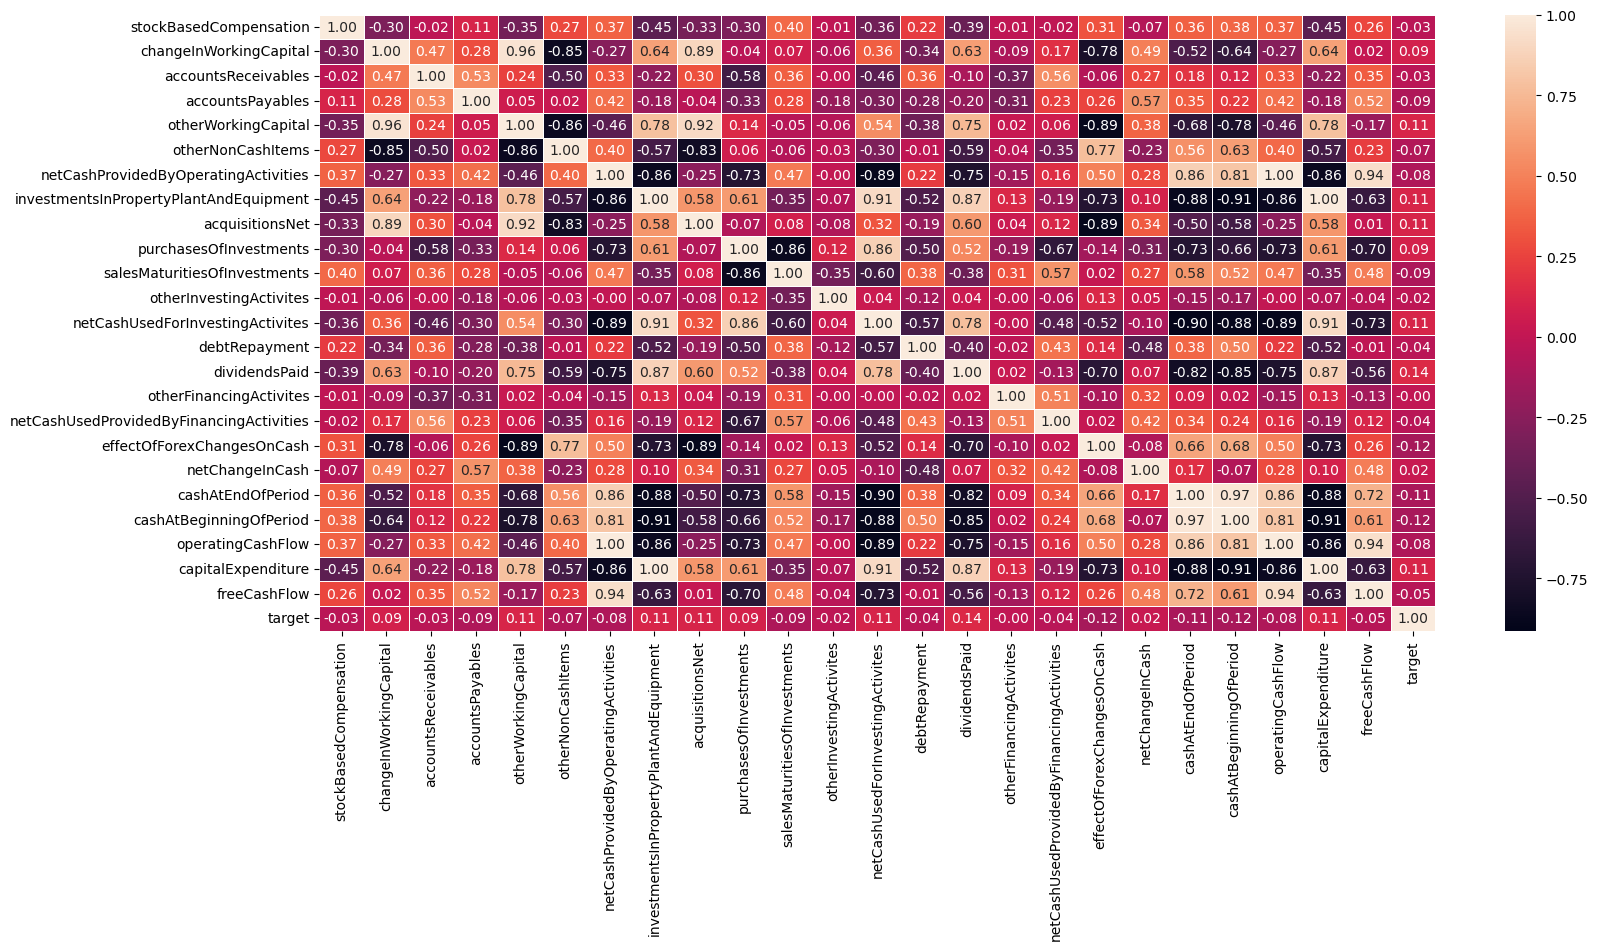

In [25]:
corr = cashflow_statement.iloc[:, 2:].corr()

plt.figure(figsize=(18, 8))
sns.heatmap(corr, annot=True, linewidth=0.5, fmt='.2f');

We will remove all features with correlation between -0.05 and 0.05 due to having very low correlation with target value.

In [26]:
cashflow_statement.drop(["stockBasedCompensation", "accountsReceivables", "otherInvestingActivites", "debtRepayment", "netChangeInCash"], axis=1, inplace=True)

## Summary

Ultimately we've taken very conservative approach to decrease the number of features in our dataset - we've focused on removing columns which don't have any direct impact on a company valuation, as well as perform correlation analysis to remove features with very low correlation.

For correlation analysis we can notice that all features have relatively low values, none exceeding 0.2 (or lower than -0.2). As such we can't expect any one value to have decisive sway on our models. For income statement we could consider taking one step further and removing most columns that have a very high to nigh perfect correlation with other features (like revenue and grossProfit). Similarly we can look for the same in balance sheet.

For any future analysis we could also consider adding some price to earnings (PE), book value (BV) or liquidity ratios, which are commonly used by investors in assessing stock prices. Additionally we could add common valuation metrics like DCF which may help models predict future market caps. All these values are available on the API that was used in data extraction.

## Exporting enriched data

In [27]:
income_statement_export = income_statement.drop(["target"], axis=1)
balance_sheet_export = balance_sheet.drop(["date", "symbol", "target"], axis=1)
cashflow_statement_export = cashflow_statement.drop(["date", "symbol"], axis=1)

enriched_df = pd.concat([income_statement_export, balance_sheet_export, cashflow_statement_export], axis=1)

In [28]:
enriched_df.shape

(300, 81)

In [29]:
# enriched_df.to_parquet("training_data_enriched.parquet") # <-- uncomment to create new file